In [1]:
import QuantLib as ql
import numpy as np
from timeit import default_timer as timer

# option data
calculation_date = ql.Date(27, 10, 2019)
maturity_date = ql.Date(30, 10, 2020)
stock_price = ql.SimpleQuote(150.0)
strike_price = 150.0
volatility = ql.SimpleQuote(0.10) # the historical vols for a year
dividend_rate =  ql.SimpleQuote(0.002)
risk_free_rate = ql.SimpleQuote(0.003)
option_type = ql.Option.Put
barrier = 160.0
barrier_type = ql.Barrier.UpOut
rebate = 0.0

day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

ql.Settings.instance().evaluationDate = calculation_date

# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

spot_handle = ql.QuoteHandle(stock_price)
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, ql.QuoteHandle(risk_free_rate), day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, ql.QuoteHandle(dividend_rate), day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, ql.QuoteHandle(volatility), day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)


In [2]:
option = ql.BarrierOption(barrier_type, barrier, rebate, 
                       payoff, 
                       ql.EuropeanExercise(maturity_date))
option.setPricingEngine(ql.AnalyticBarrierEngine(bsm_process))
trueValue = option.NPV()

print("The theoretical price is ", trueValue)

The theoretical price is  5.2214083456793166


In [3]:
#variable names need to be changed

class BarrierOption:
    def __init__(self, calculation_date, maturity, stock_price, strike_price, volatility, dividend_rate, risk_free_rate, option_type, barrier, barrier_type, rebate):
        self.maturity = maturity
        self.stock_price = stock_price
        self.strike_price = strike_price
        self.volatility = volatility
        self.dividend_rate = dividend_rate
        self.risk_free_rate = risk_free_rate
        self.option_type = option_type
        self.calculation_date = calculation_date
        self.barrier = barrier
        self.barrier_type = barrier_type
        self.rebate = rebate
        self.bs_price = -1
        
        
    def BSM_price(self):
        day_count = ql.Actual365Fixed()
        calendar = ql.UnitedStates()
        ql.Settings.instance().evaluationDate = self.calculation_date
        
        payoff = ql.PlainVanillaPayoff(self.option_type, self.strike_price)
        exercise = ql.EuropeanExercise(self.maturity)
        european_option = ql.VanillaOption(payoff, exercise)
        spot_handle = ql.QuoteHandle(ql.SimpleQuote(self.stock_price))
        flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, ql.QuoteHandle(ql.SimpleQuote(self.risk_free_rate)), day_count))
        dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(self.calculation_date, ql.QuoteHandle(ql.SimpleQuote(self.dividend_rate)), day_count))
        flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(self.calculation_date, calendar, ql.QuoteHandle(ql.SimpleQuote(self.volatility)), day_count))
        bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                                   dividend_yield, 
                                                   flat_ts, 
                                                   flat_vol_ts)
        option = ql.BarrierOption(self.barrier_type, self.barrier, self.rebate, 
                       payoff, exercise)
        option.setPricingEngine(ql.AnalyticBarrierEngine(bsm_process))
        trueValue = option.NPV()
        self.bs_price = trueValue
        return self.bs_price
    
    def data_set(self):
        '''
        Funtion to return a set of required data for one sample for training purpose.
        
        '''
        if self.bs_price == -1:
            self.BSM_price()
        maturity_in_year = (self.maturity - self.calculation_date)/365
        data_set = (self.stock_price, self.strike_price,self.barrier, maturity_in_year, self.dividend_rate, self.volatility, self.risk_free_rate, self.rebate, self.bs_price)
        return data_set

In [4]:
stock_price = 150.0
barrier_price = 160.0
rebate = 0.0
volatility = 0.1
risk_free_rate = 0.003
dividend_rate = 0.002
barrier = BarrierOption(calculation_date, maturity_date, stock_price, strike_price, volatility, 
                        dividend_rate, risk_free_rate, option_type, barrier_price, barrier_type, rebate
                        )
print('barrier price: ', barrier.BSM_price())

barrier price:  5.2214083456793166


In [37]:
from statistics import *
from math import sqrt
import matplotlib as mpl
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

def CheckAccuracy(y,y_hat):
    stats = dict()
    
    stats['diff'] = y - y_hat
    
    stats['mse'] = mean(stats['diff']**2)
    print("Mean Squared Error:      ", stats['mse'])
    
    stats['rmse'] = sqrt(stats['mse'])
    print("Root Mean Squared Error: ", stats['rmse'])
    
    stats['mae'] = mean(abs(stats['diff']))
    print("Mean Absolute Error:     ", stats['mae'])
    
    stats['mpe'] = sqrt(stats['mse'])/mean(y)
    print("Mean Percent Error:      ", stats['mpe'])
    
    #plots
    mpl.rcParams['agg.path.chunksize'] = 100000
    mpl.pyplot.figure(figsize=(14,10))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20,fontname='Times New Roman')
    plt.ylabel('Predicted Price',fontsize=20,fontname='Times New Roman') 
    plt.show()
    
    mpl.pyplot.figure(figsize=(14,10))
    plt.hist(stats['diff'], bins=50,edgecolor='black',color='white')
    plt.xlabel('Diff')
    plt.ylabel('Density')
    plt.show()
    
    #return stats


In [5]:
import datetime
import random
import pandas as pd

'''Date helper functions'''
def xldate_to_datetime(xldate):
    temp = datetime.datetime(1899, 12, 30)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

def ql_to_datetime(d):
    return datetime.datetime(d.year(), d.month(), d.dayOfMonth())

def datetime_to_xldate(date):
    temp = datetime.datetime(1899, 12, 30)
    return (date - temp).days

def random_barrier_options_pd(numbers = 0):
    options = []
    start_maturity = datetime.datetime(2020,11,1)
    end_maturity = datetime.datetime(2023,10,30)
    calculation_date = datetime.datetime(2020,10,30)
    
    xldate1 = datetime_to_xldate(start_maturity)
    xldate2 = datetime_to_xldate(end_maturity)
    calculation_xldate = datetime_to_xldate(calculation_date)
    calculation_date = ql.Date(calculation_xldate)
    for number in range(numbers):
        maturity = ql.Date(random.randint(xldate1, xldate2+1))
        stock_price = random.randint(100, 501)
        strike_price = random.randint(7, 651)
        volatility = random.uniform(0.05, 0.90)
        dividend_rate = random.uniform(0, 0.003)
        risk_free_rate = random.uniform(0.001, 0.003)
        option_type = ql.Option.Put
        barrier_price = stock_price * (random.uniform(1, 1.2))
        barrier_type = ql.Barrier.UpOut
        rebate = 0.0
        option = BarrierOption(calculation_date, maturity, stock_price, strike_price, volatility, 
                        dividend_rate, risk_free_rate, option_type, barrier_price, barrier_type, rebate
                        )
        options.append(option.data_set())  
    dataframe = pd.DataFrame(options)
    dataframe.columns = ['stock_price', 'strike_price', 'barrier_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate', 'rebate', 'put_price']
    return dataframe

print(random_barrier_options_pd(1))


   stock_price  strike_price  barrier_price  maturity  devidends  volatility  \
0          462           315     542.785012   0.90137   0.000021    0.369544   

   risk_free_rate  rebate  put_price  
0        0.001943     0.0   8.064371  


In [15]:
n = 300000
df = random_barrier_options_pd(n)
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df['stock_price'] = df['stock_price']/df['strike_price']
df['barrier_price'] = df['barrier_price']/df['strike_price']
df['put_price'] = df['put_price']/df['strike_price']
#print(df)
#print(df.isnull().any())
n_train =  (int)(0.8 * n)
train = df[0:n_train]
X_train = train[['stock_price', 'strike_price', 'barrier_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = train['put_price'].values
test = df[n_train+1:n]
X_test = test[['stock_price', 'strike_price', 'barrier_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = test['put_price'].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

n = 300000
df = random_barrier_options_pd(n)

n_train =  (int)(0.8 * n)
train = df[0:n_train]
test = df[n_train+1:n]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_training = scaler.fit_transform(train)
scaled_testing = scaler.transform(test)
scaled_training_df = pd.DataFrame(scaled_training,columns=train.columns.values)
scaled_testing_df = pd.DataFrame(scaled_testing,columns=test.columns.values)

print("mutiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[6],scaler.min_[6]))
X_train = scaled_training_df[['stock_price','strike_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_train = scaled_training_df['call_price'].values
X_test = scaled_testing_df[['stock_price', 'strike_price','maturity', 'devidends', 'volatility', 'risk_free_rate']].values
y_test = scaled_testing_df['call_price'].values

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from keras.models import Sequential
from keras import backend
import keras
import numpy
import os

# load json and create model
json_file = open('model copy.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model_weights.h5")
print("Loaded model from disk")
loaded_model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-5,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=3,
        verbose=1)
]

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
loaded_model.fit(X_train, y_train, epochs=30, validation_split=0.2,callbacks=callbacks,
        shuffle=True, verbose=2)
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %f" % (loaded_model.metrics_names[1], score[0]))


Loaded model from disk
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 64)                512       
_________________________________________________________________
dropout_85 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 126)               8190      
_________________________________________________________________
activation_85 (Activation)   (None, 126)               0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 126)               0         
_________________________________________________________________
dense_108 (Dense)            (None, 256)               32512     
_________________________________________________________________
activation_86 (Activation)   (

Mean Squared Error:       0.004617816928813304
Root Mean Squared Error:  0.06795452103291807
Mean Absolute Error:      0.04973156442245978
Mean Percent Error:       0.7481122217675659


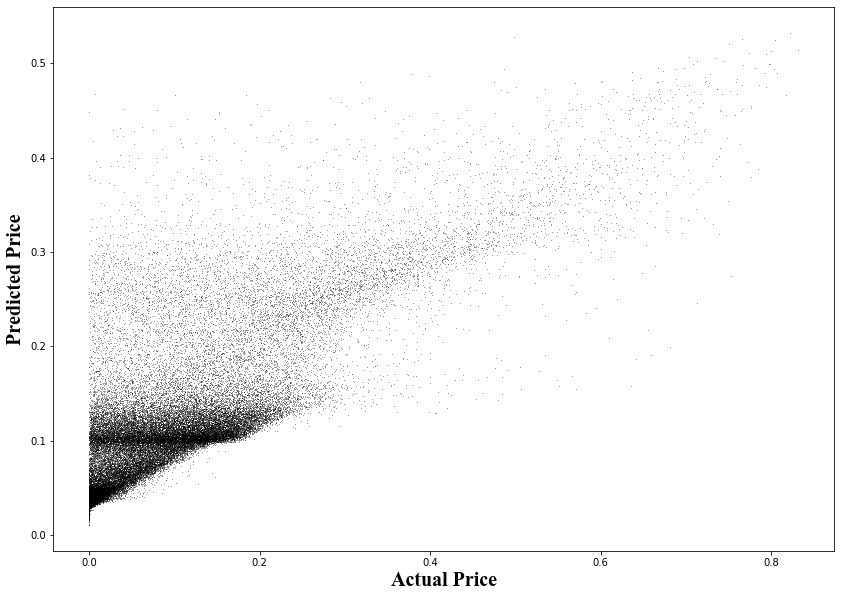

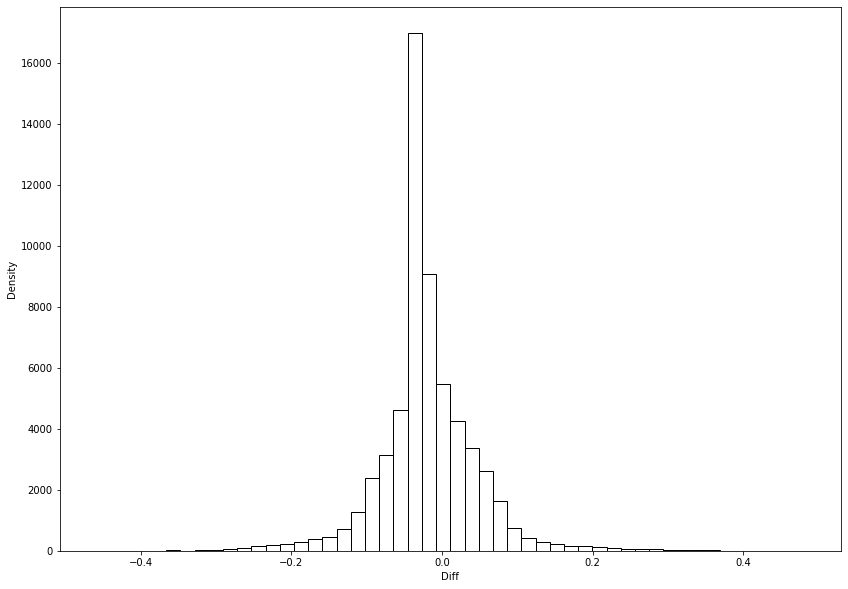

In [39]:
y_test_hat = loaded_model.predict(X_test)
y_test_hat = np.squeeze(y_test_hat)
CheckAccuracy(y_test, y_test_hat)

In [35]:
df = random_barrier_options_pd(1)
## Normalize the data exploiting the fact that the BS Model is linear homogenous in S,K
df['stock_price'] = df['stock_price']/df['strike_price']
df['barrier_price'] = df['barrier_price']/df['strike_price']
df['put_price'] = df['put_price']/df['strike_price']
df_input = df[['stock_price', 'strike_price', 'barrier_price', 'maturity', 'devidends', 'volatility', 'risk_free_rate']].values
bo_price = loaded_model.predict(df_input)[0][0] 
print('prediction price: ', bo_price * df['strike_price'].values)
print('original price: ', df['put_price'].values * df['strike_price'].values )

prediction price:  [53.37154493]
original price:  [52.40172049]


In [97]:
#barrier options

from QuantLib import *
import matplotlib.pyplot as plt
stock_price = ql.SimpleQuote(150.0)
strike_price = 150
barrier, barrierType, optionType, rebate = (160, Barrier.UpOut, Option.Put, 0.0)
underlying, strike, rf, sigma, maturity, divYield = (10, 150, 0.003, 0.1, 12, 0.002)

## maturity is in days and must be an integer 
barrier_data = dict( (name,eval(name)) for name in [
    'barrier', 'barrierType', 'optionType', 'rebate', 'underlying', 'strike', 
    'rf', 'sigma', 'maturity', 'divYield'] )
barrier_data['barrierType'] = ['DownIn', 'UpIn', 'DownOut', 'UpOut'][barrier_data['barrierType']]
barrier_data['optionType'] = ['Put', '???', 'Call'][barrier_data['optionType']+1]
for k in barrier_data.keys():
    print("{} = {}".format(k, barrier_data[k]))

ql.Settings.instance().evaluationDate = calculation_date
maturity_date = ql.Date(30, 10, 2020)

process = BlackScholesMertonProcess(
    QuoteHandle(SimpleQuote(underlying)),
    YieldTermStructureHandle(FlatForward(calculation_date, divYield, Thirty360())),
    YieldTermStructureHandle(FlatForward(calculation_date, rf, Thirty360())),
    BlackVolTermStructureHandle(BlackConstantVol(
        calculation_date, NullCalendar(), sigma, Thirty360())))
option = BarrierOption(barrierType, barrier, rebate, 
                       PlainVanillaPayoff(optionType, strike), 
                       EuropeanExercise(maturity_date))
option.setPricingEngine(AnalyticBarrierEngine(process))
trueValue = option.NPV()

print(trueValue)

barrier = 160
barrierType = UpOut
optionType = Put
rebate = 0.0
underlying = 10
strike = 150
rf = 0.003
sigma = 0.1
maturity = 12
divYield = 0.002
139.56708195098898
